<a href="https://colab.research.google.com/github/lbrogna/drone-palms/blob/main/palm_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rasterio

In [ ]:
import pickle as pkl
import torch
from torch import nn
import torch.nn.functional as F
import urllib.parse as urlparse
import os
import sys
import random
import math as m

In [ ]:
chips_path = '/content/drive/MyDrive/drone_working/chip_files/ortho_2' # path to folder containing chips
out_path = '/content/drive/MyDrive/drone_working/out' # path to folder where the final remosaicked prediction will be saved
pred_dir = '/content/drive/MyDrive/drone_working/test' # path to folder where prediction chips will be saved
ri_filepath = out_path + '/ortho2_test' # name of final prediction when saved

# the following information is printed in chip_unchip.ipynb during the chipping process
image_shape = (4632, 4632) # dimensions of the original orthophoto
chip_dimensions = (662, 662) # dimensions of each chip
overlap = (1, 1)  # overlap between chips
bands = 1

# number of chips per orthophoto
chips_per_ortho = 49

# number of orthophotos to process
num_photos = 1

In [ ]:
means_filepath = '/content/drive/MyDrive/drone_working/compilation_materials/means.pkl'
stds_filepath = '/content/drive/MyDrive/drone_working/compilation_materials/stds.pkl'

with open(means_filepath, "rb") as means_file:
    means = tuple(pkl.load(means_file))

with open(stds_filepath, "rb") as stds_file:
    stds = tuple(pkl.load(stds_file))

In [ ]:
config = {

    "working_dir" : "/content/drive/MyDrive/drone_working",
    "out_dir" : "/content/drive/MyDrive/drone_working/out",

    # Model
    "model_name" : "unet",
    "img_bands" : 3,
    "class_numbers" : 2,
    "drop_rate" : 0.15,
    "buffer" : 0,

    # Compiler
    "gpus" : [0],

    "init_params" : "/content/drive/MyDrive/drone_working/compilation_materials/with_drop_0.15_final_state.pth",
    "freeze_params": list(range(58))
}

In [ ]:
class ModelCompiler:
    """
    Compiler of specified model
    Args:
        model (''nn.Module''): pytorch model for segmentation
        buffer (int): distance to sample edges not considered in optimization
        gpuDevices (list): indices of gpu devices to use
        params_init (dict object): initial model parameters
        freeze_params (list): list of indices for parameters to keep frozen
    """

    def __init__(self, model, buffer, gpuDevices=[0], params_init=None, freeze_params=None):

        self.working_dir = config["working_dir"]
        self.out_dir = config["out_dir"]

        # model
        self.gpuDevices = gpuDevices
        self.model = model

        self.model_name = self.model.__class__.__name__

        if params_init:
            self.load_params(params_init, freeze_params)

        self.buffer = buffer

        # gpu
        self.gpu = torch.cuda.is_available()

        if self.gpu:
            print('----------GPU available----------')
            # GPU setting
            if gpuDevices:
                torch.cuda.set_device(gpuDevices[0])
                self.model = torch.nn.DataParallel(self.model, device_ids=gpuDevices)
            self.model = self.model.cuda()

        num_params = sum([p.numel() for p in self.model.parameters() if p.requires_grad])
        print("total number of trainable parameters: {:2.1f}M".format(num_params / 1000000))

        if params_init:
            print("---------- Pre-trained model compiled successfully ----------")
        else:
            print("---------- Vanilla Model compiled successfully ----------")

    def load_params(self, dir_params, freeze_params):

        params_init = urlparse.urlparse(dir_params)

        inparams = torch.load(params_init.path)

        ## overwrite model entries with new parameters
        model_dict = self.model.state_dict()

        if "module" in list(inparams.keys())[0]:
            inparams_filter = {k[7:]: v.cpu() for k, v in inparams.items() if k[7:] in model_dict}

        else:
            inparams_filter = {k: v.cpu() for k, v in inparams.items() if k in model_dict}
        model_dict.update(inparams_filter)
        # load new state dict
        self.model.load_state_dict(model_dict)

        # free some layers
        if freeze_params != None:
            for i, p in enumerate(self.model.parameters()):
                if i in freeze_params:
                    p.requires_grad = False
        return self.model

    def fit(self, trainDataset, valDataset, epochs, optimizer_name, lr_init, lr_policy,
            criterion, momentum = None, resume=False, resume_epoch=None, **kwargs):

        self.model_dir = "{}/{}/{}_ep{}".format(self.working_dir, self.out_dir, config["model_name"], config["epochs"])

        if not os.path.exists(Path(self.working_dir) / self.out_dir / self.model_dir):
            os.makedirs(Path(self.working_dir) / self.out_dir / self.model_dir)

        self.checkpoint_dir = Path(self.working_dir) / self.out_dir / self.model_dir / "chkpt"
        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)

        os.chdir(Path(self.working_dir) / self.out_dir / self.model_dir)

        print("-------------------------- Start training --------------------------")
        start = datetime.now()

        writer = SummaryWriter('./')
        lr = lr_init
        train_loss = []
        val_loss = []

        optimizer = get_optimizer(optimizer_name,
                                  filter(lambda p: p.requires_grad, self.model.parameters()),
                                  lr,
                                  momentum)

        # initialize different learning rate scheduler
        lr_policy = lr_policy.lower()
        if lr_policy == "StepLR".lower():
            step_size = kwargs.get("step_size", 10)
            gamma = kwargs.get("gamma", 0.5)
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer, step_size=step_size, gamma=gamma)

        elif lr_policy == "MultiStepLR".lower():
            milestones = kwargs.get("milestones", [10, 20, 30, 40, 50, 60, 70, 80, 90])
            gamma = kwargs.get("gamma", 0.5)
            scheduler = torch.optim.lr_scheduler.MultiStepLR(
                optimizer, milestones=milestones, gamma=gamma,
            )

        elif lr_policy == "ReduceLROnPlateau".lower():
            mode = kwargs.get('mode', 'min')
            factor = kwargs.get('factor', 0.8)
            patience = kwargs.get('patience', 3)
            threshold = kwargs.get('threshold', 0.0001)
            threshold_mode = kwargs.get('threshold_mode', 'rel')
            min_lr = kwargs.get('min_lr', 3e-6)
            verbose = kwargs.get('verbose', True)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode=mode, factor=factor, patience=patience, threshold=threshold,
                threshold_mode=threshold_mode, min_lr=min_lr, verbose=verbose
            )

        elif lr_policy == "PolynomialLR".lower():
            max_decay_steps = kwargs.get('max_decay_steps', 100)
            min_learning_rate = kwargs.get('min_learning_rate', 1e-5)
            power = kwargs.get('power', 0.8)
            scheduler = PolynomialLR(
                optimizer, max_decay_steps=max_decay_steps, min_learning_rate=min_learning_rate,
                power=power
            )

        elif lr_policy == "CyclicLR".lower():
            base_lr = kwargs.get('base_lr', 3e-5)
            max_lr = kwargs.get('max_lr', 0.01)
            step_size_up = kwargs.get('step_size_up', 1100)
            mode =  kwargs.get('mode', 'triangular')
            scheduler = torch.optim.lr_scheduler.CyclicLR(
                optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size_up,
                mode=mode
            )

        else:
            scheduler = None

        if resume:
            model_state_file = os.path.join(
                self.checkpoint_dir,
                f"{resume_epoch}_checkpoint.pth.tar"
            )

            # Resume the model from the specified checkpoint in the config file.
            if os.path.exists(model_state_file):
                print(f"Model is resumed from checkpoint: {model_state_file}")
                checkpoint = torch.load(model_state_file)
                resume_epoch = checkpoint["epoch"]
                scheduler.load_state_dict(checkpoint["scheduler"])
                self.model.load_state_dict(checkpoint["state_dict"])
                optimizer.load_state_dict(checkpoint["optimizer"])
                train_loss = checkpoint["train_loss"]
                val_loss = checkpoint["val_loss"]
            else:
                raise ValueError(f"{model_state_file} does not exist")

        if resume:
            iterable = range(resume_epoch, epochs)
        else:
            iterable = range(epochs)

        for t in iterable:

            print(f"[{t+1}/{epochs}]")

            # start fitting
            start_epoch = datetime.now()
            train(trainDataset, self.model, criterion, optimizer, scheduler,
                  gpu=self.gpu, trainLoss=train_loss)
            validate(valDataset, self.model, criterion, 0,
                     gpu=self.gpu, valLoss=val_loss)

            # Update the scheduler
            if lr_policy in ["StepLR".lower(), "MultiStepLR".lower()]:
                scheduler.step()
                print(f"LR: {scheduler.get_last_lr()}")

            if lr_policy == "ReduceLROnPlateau".lower():
                scheduler.step(val_loss[t])

            if lr_policy == "PolynomialLR".lower():
                scheduler.step(t)
                print(f"LR: {optimizer.param_groups[0]['lr']}")

            # time spent on single iteration
            print('time:', (datetime.now() - start_epoch).seconds)

            writer.add_scalars(
                "Loss",
                {"train_loss": train_loss[t],
                 "val_loss": val_loss[t]},
                 t + 1)

            checkpoint_interval = 2 # e.g. save every 10 epochs
            if (t+1) % checkpoint_interval == 0:
                torch.save(
                    {
                        "epoch": t+1,
                        "state_dict": self.model.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "train_loss": train_loss,
                        "val_loss": val_loss
                    }, os.path.join(
                        self.checkpoint_dir,
                        f"{t+1}_checkpoint.pth.tar")
                )

        writer.close()
        return train_loss, val_loss
        print(f"-------------------------- Training finished in {(datetime.now() - start).seconds}s --------------------------")


    def evaluate(self, evalDataset, csv_fn):

        if not os.path.exists(Path(self.working_dir) / self.out_dir):
            os.makedirs(Path(self.working_dir) / self.out_dir)

        print('-------------------------- Start evaluation --------------------------')
        start = datetime.now()

        # evaluate(evalData, model, buffer, gpu, csv_fn)
        print(start)
        evaluate(evalDataset, self.model, self.buffer, self.gpu, csv_fn)

        print(f"-------------------------- Evaluation finished in {(datetime.now() - start).seconds}s --------------------------")


    def predict(self, image_array):

        print('-------------------------- Start prediction --------------------------')
        start = datetime.now()

        out = predict(image_array, self.model)


        print('-------------------------- Prediction finished in {}s --------------------------' \
              .format((datetime.now() - start).seconds))
        return out

    def save(self, name, object = "params"):

        if object == "params":
            torch.save(self.model.state_dict(),
                       os.path.join(self.checkpoint_dir, "{}_final_state.pth".format(name)))

            print("--------------------- Model parameters is saved to disk ---------------------")

        elif object == "model":
            torch.save(self.model,
                       os.path.join(self.checkpoint_dir, "{}_final_state.pth".format(name)))

        else:
            raise ValueError("Improper object type.")

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class DoubleConvdrop(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, drop_rate):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=drop_rate)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, drop_rate):
      super().__init__()
      self.maxpool_conv = nn.Sequential(
          nn.MaxPool2d(2),
          DoubleConvdrop(in_channels, out_channels, drop_rate)
      )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diff_y = torch.tensor([x2.size()[2] - x1.size()[2]])
        diff_x = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class unet(nn.Module):
    def __init__(self, n_channels, n_classes, drop_rate, bilinear=True):
        super(unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.drop_rate = drop_rate

        self.inc = DoubleConvdrop(n_channels, 64, drop_rate)
        self.down1 = Down(64, 128, drop_rate)
        self.down2 = Down(128, 256, drop_rate)
        self.down3 = Down(256, 512, drop_rate)
        self.down4 = Down(512, 512, drop_rate)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
model = unet(config["img_bands"], config["class_numbers"], config["drop_rate"])

model_compiler = ModelCompiler(
    model=model,
    buffer=config["buffer"],
    gpuDevices=config["gpus"],
    params_init=config['init_params'],
    freeze_params=["freeze_params"])

model_compiler.load_params('/content/drive/MyDrive/drone_working/chkpt/4_checkpoint.pth.tar', freeze_params=None)

----------GPU available----------
total number of trainable parameters: 13.4M
---------- Pre-trained model compiled successfully ----------


DataParallel(
  (module): unet(
    (inc): DoubleConvdrop(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Dropout2d(p=0.15, inplace=False)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConvdrop(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3):

In [ ]:
import rasterio
import numpy as np

# code modified from sam
def norm_img(img, means, sds):
    '''
    Data normalization with min/max method
    Params:
        img (narray): The targeted image for normalization
    Returns:
        narrray
    '''
    img = img.astype(np.float32)
    normalized = np.empty(img.shape)
    for i in range(3):
        normalized[i, :, :] = (img[i, :, :] - means[i]) / stds[i]

    return normalized

def load_data(dataPath, usage="predict", isLabel=False,
              normalize=False, means=None, stds=None):
    '''
    Read geographic data into numpy array
    Params:
        dataPath (str): Path of data to load
        normalize (bool): Apply normalization or not
        means (tuple): tuple of means for normalization
        stds (tuple): tuple of stds for normalization

    Returns:
        narray
    '''

    with rasterio.open(dataPath, "r") as src:
      meta = src.meta
      meta["dtype"] = "int16"
      img = src.read()
      if normalize:
          img = norm_img(img, means, stds)
    return img , meta

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from rasterio.plot import show

def plot_predictions(img, pred):
    print("Image shape:", img.shape)
    print("Prediction shape:", pred.shape)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

    # Display the RGB image using PIL.Image
    # img_rgb = img.transpose(1, 2, 0)
    show(img, ax=axs[0], adjust=True)
    axs[0].set_title('Image')
    axs[0].axis('off')

    pred_channel = pred.squeeze()
    axs[1].imshow(pred_channel, cmap='viridis')
    axs[1].set_title('Prediction')
    axs[1].axis('off')

In [ ]:
import torch
from torch.autograd import Variable

thresh = 0.5  # minimum value for soft prediction that will be rounded to 1 when made hard

preds = []
imgs = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

chip_files = [f for f in os.listdir(chips_path) if f.endswith(('.tif'))]

for chip in chip_files:

    out_name = chip[0:-4] + '_pred'

    img_file = chips_path + '/' + chip
    img, meta = load_data(img_file, normalize=True, means=means, stds=stds)
    imgs.append(img)
    img = np.expand_dims(img, 0).transpose(0, 1, 3, 2)
    img = torch.from_numpy(img).to(device)
    img = img.float()

    model = model_compiler.model
    model = model.to(device)
    model.eval()
    img = Variable(img, requires_grad=False)

    pred = model(img)
    pred_prob = F.softmax(pred, 1)

    nodata = -32768 if meta["dtype"] == "int16" else np.nan

    meta.update(nodata=nodata, count=1)
    meta["nodata"] = -1

    soft_prediction = pred_prob[:, 1, :, :].cpu().detach().numpy()
    highest_suit = max(max(soft_prediction).flatten())
    soft_prediction = soft_prediction / highest_suit
    hard_prediction = np.zeros_like(soft_prediction)
    hard_prediction[soft_prediction >= thresh] = 1
    hard_prediction = np.transpose(hard_prediction, [0, 2, 1])
    preds.append(hard_prediction)

    # Save the numpy array to the specified file path
    np.save(pred_dir + f"/hard_{out_name}", hard_prediction)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


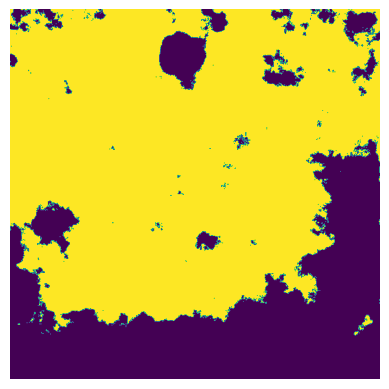

In [ ]:
# test load a certain pred chip from the specified file path
loaded_data = np.load('/content/drive/MyDrive/drone_working/test/hard_chip_47_pred.npy')
channel = loaded_data.squeeze()
plt.imshow(channel, cmap='viridis')
plt.axis('off')
plt.show()

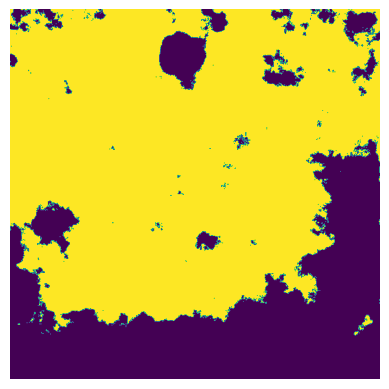

In [ ]:
channel = preds[-2].squeeze()
plt.imshow(channel, cmap='viridis')
plt.axis('off')
plt.show()

Image shape: (3, 662, 662)
Prediction shape: (1, 662, 662)


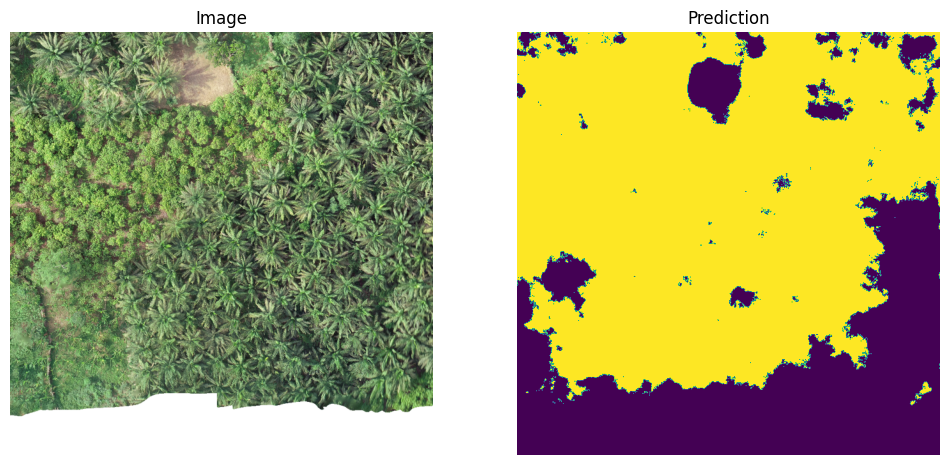

In [ ]:
i = -2
plot_predictions(imgs[i], preds[i])

In [ ]:
def remosaic(chips, image_shape, chip_dimensions, overlap, bands):
    # get image dimensions
    height, width = image_shape

    # initialize an empty canvas to reconstruct the image
    remosaicked_img = np.zeros((bands, height, width), dtype=np.float32)

    overlap_counts = np.zeros((height, width), dtype=np.uint8)

    # calculate the overlap between chips
    overlap_y, overlap_x = overlap

    # parse chip dims into seperate vars
    chip_h, chip_w = chip_dimensions

    # calculate the number of chips in each direction
    num_chips_y = int(np.ceil(height / chip_h))
    num_chips_x = int(np.ceil(width / chip_w))

    # reconstruct the image by placing each chip in the correct location
    chip_idx = 0

    for i in range(num_chips_y):
        for j in range(num_chips_x):
            y_start = i * (chip_h - overlap_y)
            y_end = min(y_start + chip_h, height)

            x_start = j * (chip_w - overlap_x)
            x_end = min(x_start + chip_w, width)

            chip = chips[chip_idx]

            # accumulate the chip into the reconstructed image
            remosaicked_img[:, y_start:y_end, x_start:x_end] += chip[:, :y_end-y_start, :x_end-x_start]
            overlap_counts[y_start:y_end, x_start:x_end] += 1

            chip_idx += 1
            if chip_idx >= len(chips):
                break
        if chip_idx >= len(chips):
            break

    overlap_counts = np.expand_dims(overlap_counts, axis=0)

    # average the overlapping regions
    remosaicked_img /= np.maximum(overlap_counts[...], 1)

    # convert the image back to uint8 data type
    remosaicked_img = np.round(remosaicked_img).astype(np.uint8)



    return remosaicked_img

In [ ]:
# reconstruct the orthophoto from chips
remosaicked_img = remosaic(preds, image_shape, chip_dimensions, overlap, bands)

np.save(ri_filepath, remosaicked_img)

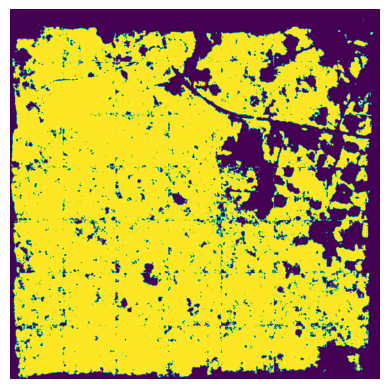

In [ ]:
# display the image
channel = remosaicked_img.squeeze()
plt.imshow(channel, cmap='viridis')
plt.axis('off')
plt.show()

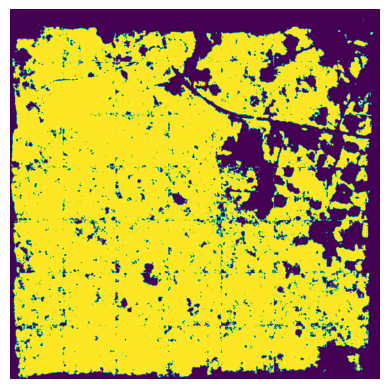

In [ ]:
# test load full prediction from filepath
loaded_data = np.load(ri_filepath + '.npy')
channel = loaded_data.squeeze()
plt.imshow(channel, cmap='viridis')
plt.axis('off')
plt.show()